In [13]:
import numpy as np
from skimage import draw, morphology
import math
from svgpathtools import parse_path
from matplotlib.path import Path
import scipy.sparse as sp
import io

import zipfile

In [14]:
global_store = {'dragmode': 'drawrect', 'visible': True, 'view': {}, 'active_img_shape': [1280, 544], 'image_shapes': [[1280, 544]], 'image_ratio': 0.42}
all_annotations = [{'annotations': {'0': [{'editable': True, 'label': {'text': '', 'texttemplate': ''}, 'xref': 'x', 'yref': 'y', 'layer': 'above', 'opacity': 1, 'line': {'color': 'rgb(22,17,79)', 'width': 4, 'dash': 'solid'}, 'type': 'path', 'path': 'M354.5214899713468,137.53581661891118L272.0000000000001,137.53581661891118L238.9914040114614,150.37249283667623L196.81375358166198,194.3839541547278L171.1404011461319,245.730659025788L167.4727793696276,308.08022922636104L165.63896848137546,425.44412607449857L150.96848137535827,496.9627507163324L112.45845272206313,584.9856733524356L73.94842406876799,640L68.44699140401154,649.1690544412608'}, {'editable': True, 'label': {'text': '', 'texttemplate': ''}, 'xref': 'x', 'yref': 'y', 'layer': 'above', 'opacity': 1, 'line': {'color': 'rgb(22,17,79)', 'width': 4, 'dash': 'solid'}, 'fillcolor': 'rgb(22,17,79)', 'fillrule': 'evenodd', 'type': 'path', 'path': 'M213.31805157593132,740.8595988538682L268.3323782234958,779.3696275071634L321.5128939828081,852.7220630372493L350.8538681948425,889.3982808022923L367.35816618911184,889.3982808022923L389.36389684813764,869.2263610315186L407.70200573065915,836.21776504298L418.704871060172,779.3696275071634L416.87106017191985,715.1862464183381L393.03151862464193,645.5014326647565L354.5214899713468,583.1518624641834Z'}, {'editable': True, 'label': {'text': '', 'texttemplate': ''}, 'xref': 'x', 'yref': 'y', 'layer': 'above', 'opacity': 1, 'line': {'color': 'rgb(22,17,79)', 'width': 4, 'dash': 'solid'}, 'fillcolor': 'rgb(22,17,79)', 'fillrule': 'evenodd', 'type': 'circle', 'x0': 415.2755389155966, 'y0': 336.1310524814334, 'x1': 513.8247476173549, 'y1': 81.97783004005662}]}, 'color': 'rgb(22,17,79)', 'label': 'class 1', 'is_visible': True}, {'annotations': {'147': [{'editable': True, 'label': {'text': '', 'texttemplate': ''}, 'xref': 'x', 'yref': 'y', 'layer': 'above', 'opacity': 1, 'line': {'color': 'rgb(255, 3, 3)', 'width': 4, 'dash': 'solid'}, 'fillcolor': 'rgb(255, 3, 3)', 'fillrule': 'evenodd', 'type': 'rect', 'x0': 132.63037249283676, 'y0': 401.60458452722065, 'x1': 273.83381088825223, 'y1': 548.3094555873926}]}, 'color': 'rgb(255, 3, 3)', 'label': 'Test', 'is_visible': True}]

In [82]:
class Annotations:
    def __init__(self, annotation_store, global_store):

        if annotation_store:
            slices = []
            for annotation_class in annotation_store:
                slices.extend(list(annotation_class["annotations"].keys()))
            slices = set(slices)
            annotations = {key: [] for key in slices}

            for annotation_class in annotation_store:
                
                for image_idx, slice_data in annotation_class["annotations"].items():
                    for shape in slice_data:
                        self._set_annotation_type(shape)
                        self._set_annotation_svg(shape)
                        # the id of the annotation is the concatenation of its rgb color
                        id = int(
                            annotation_class["color"]
                            .replace("rgb(", "")
                            .replace(")", "")
                            .replace(", ", "")
                            .replace(",", "")
                        )
                        annotation = {
                            "id": id,
                            "type": self.annotation_type,
                            "class": annotation_class["label"],
                            "line_width": shape["line"]["width"],
                            # TODO: This is the same across all images in a dataset
                            "image_shape": global_store["image_shapes"][0],
                            "svg_data": self.svg_data,
                        }
                        annotations[image_idx].append(annotation)
        else:
            annotations = []

        self.annotations = annotations

    def get_annotations(self):
        return self.annotations

    def get_annotation_mask(self):
        return self.annotation_mask

    def get_annotation_mask_as_bytes(self):
        buffer = io.BytesIO()
        zip_buffer = io.BytesIO()
        file_extension = "sp" if self.sparse else "npy"

        # Step 1: Save each numpy array to a separate .npy file in buffer
        npy_files = []
        for i, arr in enumerate(self.annotation_mask):
            item = self.annotation_store["annotations"].items()
            idx = list(item)[i][0]
            npy_buffer = io.BytesIO()
            np.save(npy_buffer, arr)
            npy_files.append((f"mask_{idx}.{file_extension}", npy_buffer.getvalue()))

        # Step 2: Add the .npy files to a .zip file using buffer
        with zipfile.ZipFile(zip_buffer, "w", zipfile.ZIP_DEFLATED) as zipf:
            for filename, data in npy_files:
                zipf.writestr(filename, data)

        # Get the .zip file data and file extension
        zip_data = zip_buffer.getvalue()

        # Reset the buffer position to the beginning
        buffer.seek(0)
        buffer.write(zip_data)

        return buffer.getvalue()

    def has_annotations(self):
        if self.annotations:
            return True
        return False

    def create_annotation_mask(self, sparse=False):
        self.sparse = sparse
        annotation_mask = []

        for slice_idx, slice_data in self.annotations.items():
            image_height = slice_data[0]["image_shape"][0]
            image_width = slice_data[0]["image_shape"][1]
            slice_mask = np.zeros([image_height, image_width], dtype=np.uint8)
            for shape in slice_data:
                if shape["type"] == "Closed Freeform":
                    shape_mask = ShapeConversion.closed_path_to_array(
                        shape["svg_data"], shape["image_shape"], shape["id"]
                    )
                elif shape["type"] == "Freeform":
                    shape_mask = ShapeConversion.opened_path_to_array(
                        shape["svg_data"],
                        shape["image_shape"],
                        shape["id"],
                        shape["line_width"],
                    )
                elif shape["type"] == "Rectangle":
                    shape_mask = ShapeConversion.rectangle_to_array(
                        shape["svg_data"], shape["image_shape"], shape["id"]
                    )
                elif shape["type"] == "Ellipse":
                    shape_mask = ShapeConversion.ellipse_to_array(
                        shape["svg_data"], shape["image_shape"], shape["id"]
                    )
                elif shape["type"] == "Line":
                    shape_mask = ShapeConversion.line_to_array(
                        shape["svg_data"],
                        shape["image_shape"],
                        shape["id"],
                        shape["line_width"],
                    )
                else:
                    continue
                slice_mask[shape_mask > 0] = shape_mask[shape_mask > 0]
            annotation_mask.append(slice_mask)

        if sparse:
            for idx, mask in enumerate(annotation_mask):
                annotation_mask[idx] = sp.csr_array(mask)
        self.annotation_mask = annotation_mask

    def _set_annotation_type(self, annotation):
        """
        This function returns readable annotation type name.
        """
        annotation_type = annotation["type"]

        if annotation_type == "path" and "fillrule" in annotation:
            annot = "Closed Freeform"
        elif annotation_type == "path":
            annot = "Freeform"
        elif annotation_type == "rect":
            annot = "Rectangle"
        elif annotation_type == "circle":
            annot = "Ellipse"
        elif annotation_type == "line":
            annot = "Line"
        else:
            annot = "Unknown"

        self.annotation_type = annot

    def _set_annotation_svg(self, annotation):
        """
        This function returns a dictionary of the svg data
        associated with a given annotation
        """
        if "path" in annotation.keys():
            self.svg_data = {"path": annotation["path"]}
        else:
            self.svg_data = {
                "x0": annotation["x0"],
                "x1": annotation["x1"],
                "y0": annotation["y0"],
                "y1": annotation["y1"],
            }

    def _set_annotation_line_width(self, annotation):
        """
        This function sets the line width of the annotation.
        """
        self.annotation_line_width = annotation["line"]["width"]

    def _set_annotation_class(self, annotation):
        """
        This function sets the class of the annotation.
        """
        self.annotation_class = 99
        for item in self.annotation_store["label_mapping"]:
            if item["color"] == annotation["line"]["color"]:
                self.annotation_class = item["id"]

    def _set_annotation_image_shape(self, image_idx):
        """
        This function sets the the size of the image slice
        """
        # TODO: Assuming all images in the slice are the same shape
        self.annotation_image_shape = self.annotation_store["image_shapes"][0]


class ShapeConversion:
    @classmethod
    def ellipse_to_array(self, svg_data, image_shape, mask_class):
        image_height, image_width = image_shape
        x0 = svg_data["x0"]
        y0 = svg_data["y0"]
        x1 = svg_data["x1"]
        y1 = svg_data["y1"]

        # Calculate the radius of the circle (r)
        r = math.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2)

        # Calculate the radius in x-direction (r_radius)
        r_radius = abs(x1 - x0)

        # Calculate the radius in y-direction (c_radius)
        c_radius = abs(y1 - y0)

        # Center of the circle (cx, cy)
        cx = x0
        cy = y0

        # Adjust center coordinates to fit within the image bounds
        cx = max(min(int(cx), image_width - 1), 0)
        cy = max(min(int(cy), image_height - 1), 0)

        r, cx, cy, r_radius, c_radius = int(r), cx, cy, int(r_radius), int(c_radius)

        # Scale the radius if needed to fit within the image bounds
        max_radius = min(cx, cy, image_width - cx, image_height - cy)
        r_radius = min(r_radius, max_radius)
        c_radius = min(c_radius, max_radius)

        # Create the image and draw the circle
        mask = np.zeros((image_height, image_width), dtype=np.uint8)
        rr, cc = draw.ellipse(cy, cx, r_radius, c_radius)

        # Ensure indices are within valid image bounds
        rr = np.clip(rr, 0, image_height - 1)
        cc = np.clip(cc, 0, image_width - 1)
        mask[rr, cc] = mask_class
        return mask

    @classmethod
    def rectangle_to_array(self, svg_data, image_shape, mask_class):
        image_height, image_width = image_shape
        x0 = svg_data["x0"]
        y0 = svg_data["y0"]
        x1 = svg_data["x1"]
        y1 = svg_data["y1"]

        # Adjust coordinates to fit within the image bounds
        x0 = max(min(x0, image_width - 1), 0)
        y0 = max(min(y0, image_height - 1), 0)
        x1 = max(min(x1, image_width - 1), 0)
        y1 = max(min(y1, image_height - 1), 0)

        # # Draw the rectangle
        mask = np.zeros((image_height, image_width), dtype=np.uint8)
        rr, cc = draw.rectangle(start=(y0, x0), end=(y1, x1))

        # Convert coordinates to integers
        rr = np.round(rr).astype(int)
        cc = np.round(cc).astype(int)

        mask[rr, cc] = mask_class
        return mask

    @classmethod
    def line_to_array(self, svg_data, image_shape, mask_class, line_width):
        image_height, image_width = image_shape
        x0 = svg_data["x0"]
        y0 = svg_data["y0"]
        x1 = svg_data["x1"]
        y1 = svg_data["y1"]

        # Adjust coordinates to fit within the image bounds
        x0 = max(min(int(x0), image_width - 1), 0)
        y0 = max(min(int(y0), image_height - 1), 0)
        x1 = max(min(int(x1), image_width - 1), 0)
        y1 = max(min(int(y1), image_height - 1), 0)

        mask = np.zeros((image_height, image_width), dtype=np.uint8)
        rr, cc = draw.line(y0, x0, y1, x1)
        mask[rr, cc] = mask_class
        # mask = morphology.dilation(mask, morphology.disk(radius=line_width))
        return mask

    @classmethod
    def closed_path_to_array(self, svg_data, image_shape, mask_class):
        image_height, image_width = image_shape

        # Parse the SVG path from the input string
        path = parse_path(svg_data["path"])

        # Create a filled polygon using matplotlib
        vertices = []
        for segment in path:
            vertices.extend([segment.start.real, segment.start.imag])
            if hasattr(segment, "control_points"):
                for control_point in segment.control_points:
                    vertices.extend([control_point.real, control_point.imag])

        # Create a matplotlib Path object from the vertices
        polygon_path = Path(np.array(vertices).reshape(-1, 2))

        # Generate a grid of points covering the whole image
        x, y = np.meshgrid(np.arange(0, image_width), np.arange(0, image_height))
        points = np.column_stack((x.ravel(), y.ravel()))

        # Check if each point is inside the polygon
        is_inside = polygon_path.contains_points(points)

        # Reshape the result back into the 2D shape
        mask = is_inside.reshape(image_height, image_width).astype(int)

        # Set the class value for the pixels inside the polygon
        mask[mask == 1] = mask_class
        return mask

    @classmethod
    def opened_path_to_array(self, svg_data, image_shape, mask_class, line_width):
        image_height, image_width = image_shape
        path_data = svg_data["path"]
        path = parse_path(path_data)

        # Create an empty image
        mask = np.zeros((image_height, image_width), dtype=np.uint8)

        # Convert SVG path to points and draw on the image
        for curve in path:
            for t in np.linspace(0, 1, 1000):
                x, y = curve.point(t).real, curve.point(t).imag
                x = max(min(int(x), image_width - 1), 0)
                y = max(min(int(y), image_height - 1), 0)
                # mask[y, x] = mask_class
        # mask = morphology.dilation(mask, morphology.disk(radius=line_width))
        return mask

In [83]:
annotations = Annotations(all_annotations, global_store)
annotations.get_annotations()

{'0': [{'id': 221779,
   'type': 'Freeform',
   'class': 'class 1',
   'line_width': 4,
   'image_shape': [1280, 544],
   'svg_data': {'path': 'M354.5214899713468,137.53581661891118L272.0000000000001,137.53581661891118L238.9914040114614,150.37249283667623L196.81375358166198,194.3839541547278L171.1404011461319,245.730659025788L167.4727793696276,308.08022922636104L165.63896848137546,425.44412607449857L150.96848137535827,496.9627507163324L112.45845272206313,584.9856733524356L73.94842406876799,640L68.44699140401154,649.1690544412608'}},
  {'id': 221779,
   'type': 'Closed Freeform',
   'class': 'class 1',
   'line_width': 4,
   'image_shape': [1280, 544],
   'svg_data': {'path': 'M213.31805157593132,740.8595988538682L268.3323782234958,779.3696275071634L321.5128939828081,852.7220630372493L350.8538681948425,889.3982808022923L367.35816618911184,889.3982808022923L389.36389684813764,869.2263610315186L407.70200573065915,836.21776504298L418.704871060172,779.3696275071634L416.87106017191985,715.18

In [84]:
import matplotlib.pyplot as plt

annotations.create_annotation_mask()
masks = annotations.get_annotation_mask()

/var/folders/x4/4x0nvh3n5sl_56_p336vdtl00000gn/T/ipykernel_80677/1756453213.py:223: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 221779 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  mask[rr, cc] = mask_class
/var/folders/x4/4x0nvh3n5sl_56_p336vdtl00000gn/T/ipykernel_80677/1756453213.py:248: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 25533 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  mask[rr, cc] = mask_class


In [85]:
len(masks)

2

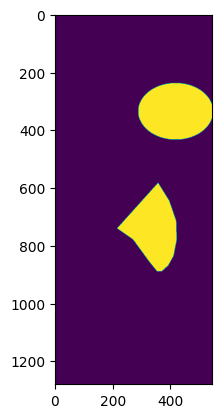

In [86]:
plt.imshow(masks[0])

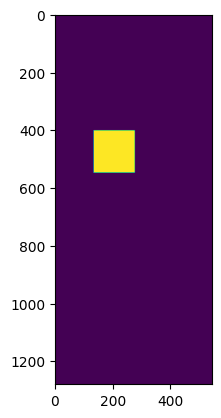

In [87]:
plt.imshow(masks[1])